Below are the instructions for the technical assessment. There are two parts: Data Science and Engineering. You should plan to spend about 1-2 hours on the Data Science portion and 1-2 hours on the engineering portion.

## Data Science

For the Data Science portion, it is important to note that your work won't be assessed on whether you get the best model, but that you understand important concepts behind analyzing the data, feature engineering and model development and evaluation. Keep this section simple, clear and illustrative of your understanding of how to prototype a model.

## Engineering

In a separate set of files (ie not in this Jupyter Notebook), take the model that you created and implement basic training and prediction pipelines that would simulate what you would implement in production. These pipelines should broadly cover the following steps:
* Preprocessing
  * This will be based off the raw data received at the beginning of DS assignment
* Model Training & Evaluation
* Predictions (in batch)

*Some Requirements*:
* The training and prediction pipelines should be independent of each other (though they can draw from the same base methods/classes if need be).
* The prediction job predicts on the latest "promoted" model.
* All model artifacts and outputs are stored according to date partition or, where relevant, by version
* The training job includes logic around "model promotion"
  * If there is an 10% increase in ROC/AUC over the previous model then promote model; else don't promote model
* For both jobs, a user (human or machine) should be able to simply call on the script or import a class to run the pipeline

*Bonus*:

Parameterize the pipelines according to how a Data Scientist would use this.
* Allow for arbitrary set of features to be passed into training (and prediction) job
* Parameterize the % threshold increase to promote a model
* Parameterize which evaluation metric can be used. To keep it simple, stick with most common metrics for evaluation


Organize the files in a folder structure that would emulate how you would organize the code in a Github repo. Zip up all files and send them back to the recruiter by the morning of your interview.

# Data Science Portion

## Imports

In [1]:
# !pip install pandas 
# !pip install numpy
# !pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
# Add any other packages you would like to use here

## Dataset

The dataset in this notebook is representive of Vacasa's internal data.

In this notebook, we would like you to develop a model to predict whether a reservation will cancel and describe what the model learned. 

* The label in the dataset is given as `is_canceled`.
* For a complete description of dataset, visit the link: https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [3]:
df = pd.read_csv('train/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


 ## Helpful EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
df['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [6]:
df['is_canceled'].mean()

0.37041628277075134

In [7]:
df.shape

(119390, 32)

In [8]:
df['reservation_status'].value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

## Visual exploration

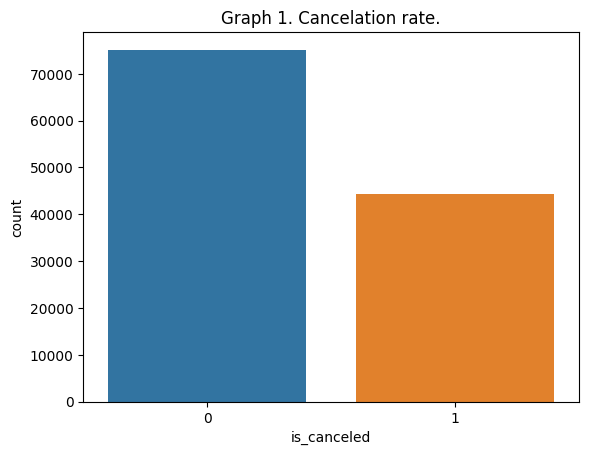

In [9]:
sns.countplot(x='is_canceled', data=df, label='Canceled').set_title('Graph 1. Cancelation rate.')
plt.show()

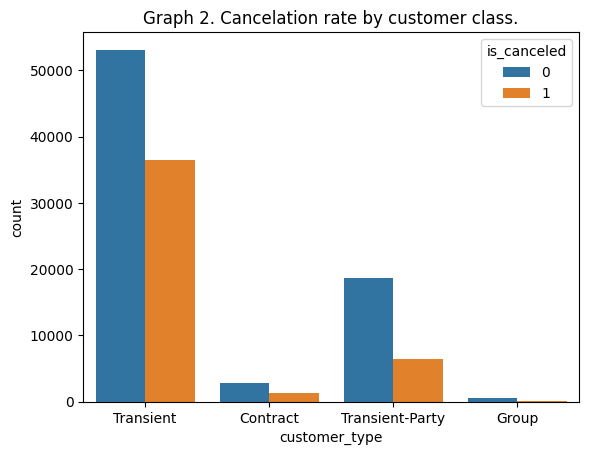

In [10]:
sns.countplot(x='customer_type', hue='is_canceled', data=df).set_title('Graph 2. Cancelation rate by customer class.')
plt.show()

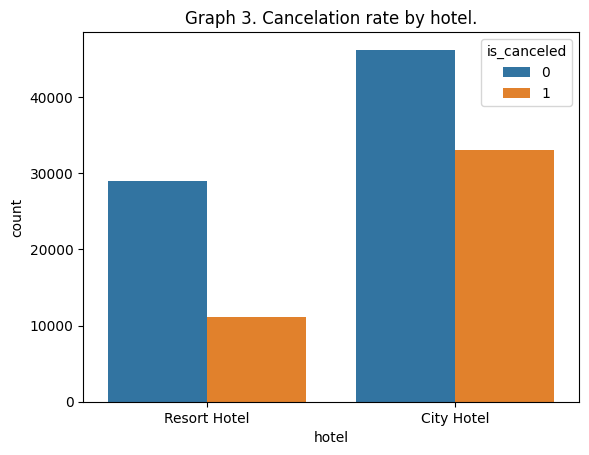

In [11]:
sns.countplot(x='hotel', hue='is_canceled', data=df).set_title('Graph 3. Cancelation rate by hotel.')
plt.show()

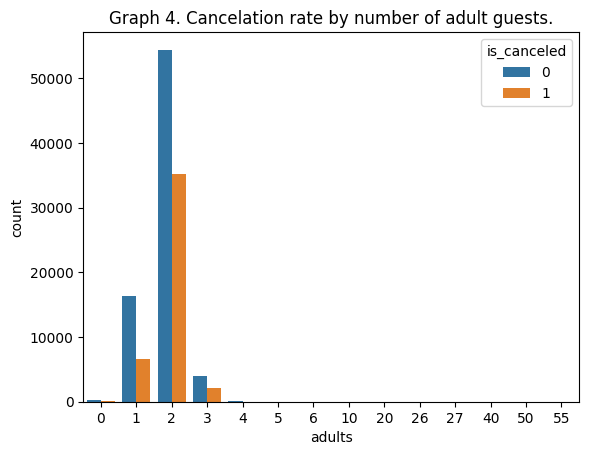

In [12]:
sns.countplot(x='adults', hue='is_canceled', data=df).set_title('Graph 4. Cancelation rate by number of adult guests.')
plt.show()

In [13]:
df_a_lot_of_adults = df[df['adults'] >= 10]
df_a_lot_of_adults.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
1539,Resort Hotel,1,304,2015,September,36,3,0,3,40,...,No Deposit,NaN,NaN,0,Group,0.0,0,0,Canceled,2015-01-02
1587,Resort Hotel,1,333,2015,September,36,5,2,5,26,...,No Deposit,96.0,NaN,0,Group,0.0,0,0,Canceled,2015-01-02
1643,Resort Hotel,1,336,2015,September,37,7,1,2,50,...,No Deposit,NaN,NaN,0,Group,0.0,0,0,Canceled,2015-01-18
1752,Resort Hotel,1,340,2015,September,37,12,2,5,26,...,No Deposit,96.0,NaN,0,Group,0.0,0,0,Canceled,2015-01-02
1884,Resort Hotel,1,347,2015,September,38,19,2,5,26,...,No Deposit,96.0,NaN,0,Group,0.0,0,0,Canceled,2015-01-02


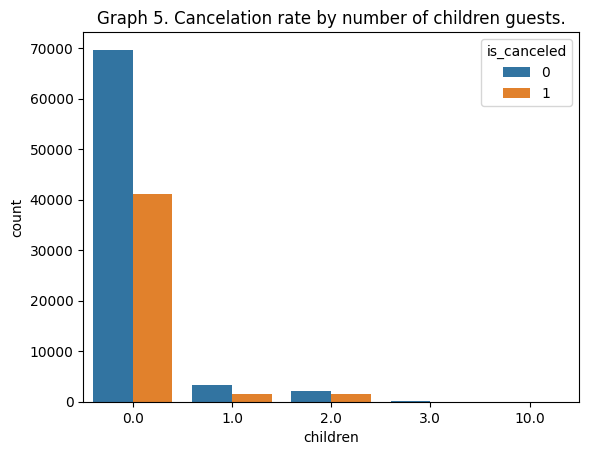

In [14]:
sns.countplot(x='children', hue='is_canceled', data=df).set_title('Graph 5. Cancelation rate by number of children guests.')
plt.show()

In [15]:
df_a_lot_of_children = df[df['children'] >= 4]
df_a_lot_of_children.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
328,Resort Hotel,1,55,2015,July,29,12,4,10,2,...,No Deposit,8.0,NaN,0,Contract,133.16,0,1,No-Show,2015-07-12


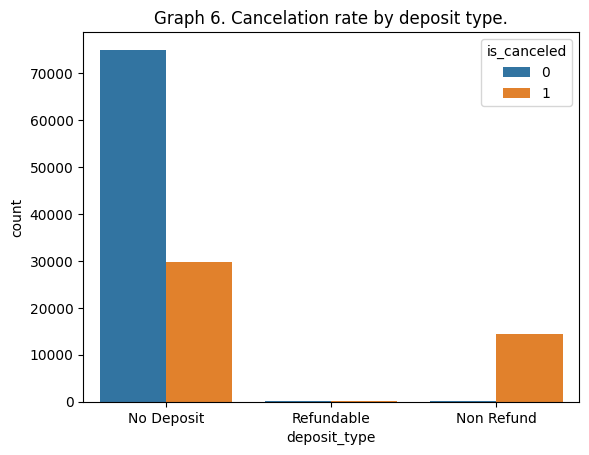

In [16]:
sns.countplot(x='deposit_type', hue='is_canceled', data=df).set_title('Graph 6. Cancelation rate by deposit type.')
plt.show()

# Let's now take a closer look at cancellations

In [17]:
# Group by month and calculate the number of loans per month
monthly_cancellations = df.groupby(['arrival_date_year', 'arrival_date_month']).size().reset_index(name='Number of cancellations')

# Calculate the total loans per year for percentage calculation
total_cancellations_per_year = df.groupby('arrival_date_year').size()

# Calculate the percentage of loans per month and year
monthly_cancellations['Percentage of cancellations (%)'] = (monthly_cancellations['Number of cancellations'] / 
                                                          monthly_cancellations.apply(lambda row: total_cancellations_per_year[row['arrival_date_year']], axis=1)) * 100

# Display the table
monthly_cancellations.head(10)

,arrival_date_year,arrival_date_month,Number of cancellations,Percentage of cancellations (%)
0,2015,August,3889,17.680487
1,2015,December,2920,13.275141
2,2015,July,2776,12.620476
3,2015,November,2340,10.638298
4,2015,October,4957,22.535916
5,2015,September,5114,23.249682
6,2016,April,5428,9.572011
7,2016,August,5063,8.928351
8,2016,December,3860,6.806920
9,2016,February,3891,6.861587


__Note:__

*Percentage of cancellations (%) column corresponds to the % of cancellations in the specific month relative to the total cancellations THIS YEAR.*

In [18]:
df_note = monthly_cancellations.head(6)
df_note.loc['Total'] = df_note.sum() #sum to 100%
df_note

C:\Users\macko\AppData\Local\Temp\ipykernel_33048\2558259349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_note.loc['Total'] = df_note.sum() #sum to 100%


,arrival_date_year,arrival_date_month,Number of cancellations,Percentage of cancellations (%)
0,2015,August,3889,17.680487
1,2015,December,2920,13.275141
2,2015,July,2776,12.620476
3,2015,November,2340,10.638298
4,2015,October,4957,22.535916
5,2015,September,5114,23.249682
Total,12090,AugustDecemberJulyNovemberOctoberSeptember,21996,100.000000


<Figure size 1400x1000 with 0 Axes>

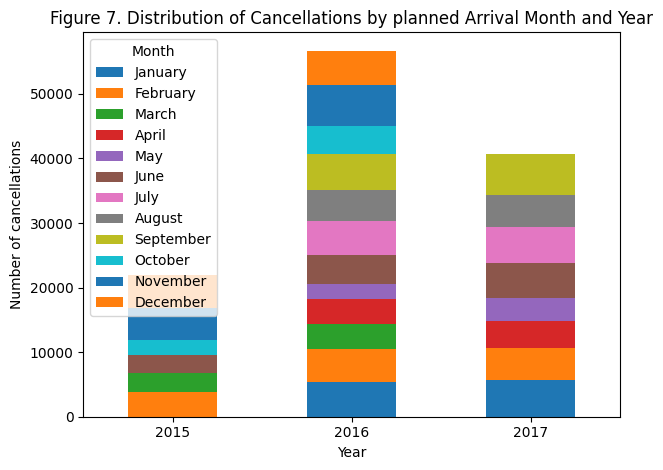

In [19]:
# Define the month names for the x-axis labels
month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Create a pivot table for the monthly loans data
pivot_table = monthly_cancellations.pivot(index='arrival_date_year', columns='arrival_date_month', values='Number of cancellations')

# Create a bar plot
plt.figure(figsize=(14, 10))
pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Year')
plt.ylabel('Number of cancellations')
plt.title('Figure 7. Distribution of Cancellations by planned Arrival Month and Year')
plt.xticks(rotation=0)
plt.legend(title='Month', labels=month_names)
plt.tight_layout()

# Show the plot
plt.show()

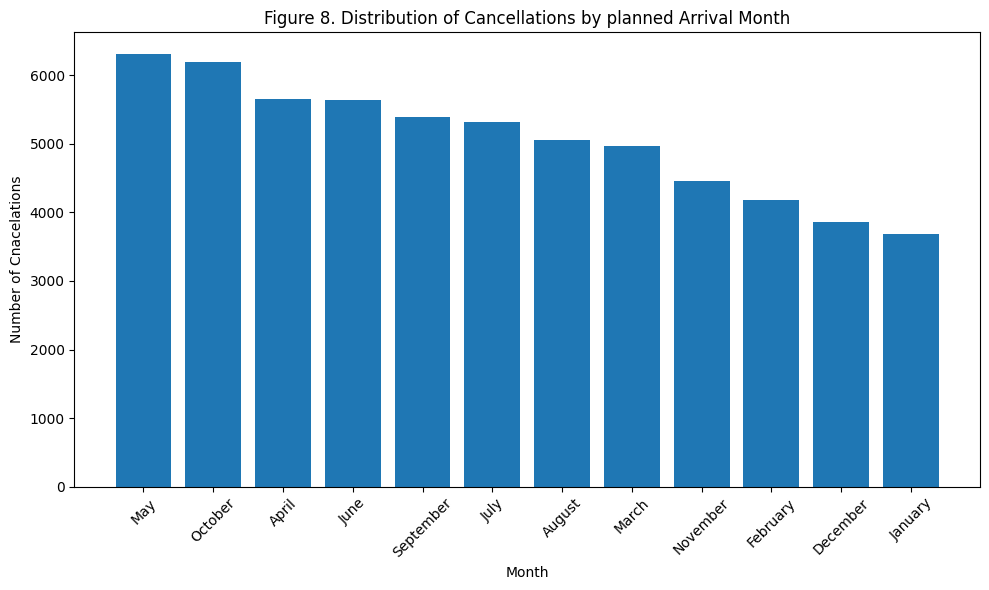

In [20]:
# Create a bar plot

monthly_cancellations = monthly_cancellations.sort_values(by='Number of cancellations', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(monthly_cancellations['arrival_date_month'], monthly_cancellations['Number of cancellations'])
plt.xlabel('Month')
plt.ylabel('Number of Cnacelations')
plt.title('Figure 8. Distribution of Cancellations by planned Arrival Month')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

- Looking at a specific year does not make a lot of sense so we will not use 'arrival_date_year' for the model. 
- However, looking at different months makes a lot of sense due to seasonality. Stays planned for May are most likely to be canceled and vice versa for January.

## Outliers and Imputing - exploration

Cols to treat:
- children
- country
- agent
- company

### Treating 'children' variable

In [21]:
df['children'].isna().sum()

4

In [22]:
df['children'].value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

10 kids is quite a lot

In [23]:
# Correlation in absolute values
df.corr()['children'].transform('abs').sort_values(ascending=False)

children                          1.000000
adr                               0.324854
total_of_special_requests         0.081745
required_car_parking_spaces       0.056253
arrival_date_year                 0.054624
booking_changes                   0.048949
stays_in_weekend_nights           0.045793
stays_in_week_nights              0.044203
agent                             0.041066
lead_time                         0.037622
days_in_waiting_list              0.033273
is_repeated_guest                 0.032859
company                           0.030931
adults                            0.030447
previous_cancellations            0.024730
babies                            0.024030
previous_bookings_not_canceled    0.021072
arrival_date_day_of_month         0.014544
arrival_date_week_number          0.005518
is_canceled                       0.005048
Name: children, dtype: float64

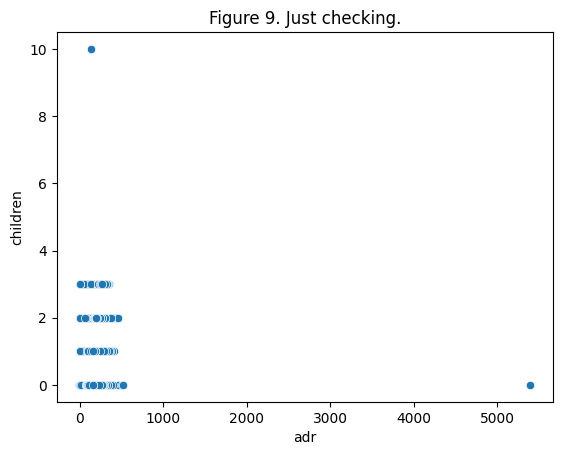

In [24]:
sns.scatterplot(x='adr', y='children', data=df).set_title('Figure 9. Just checking.')
plt.show()

There are outliers for ADR, and possibly for children.

Dropping ADRs that are negative and higher than 1000. 

In [25]:
df = df[(df['adr'] < 1000) & (df['adr'] >= 0)]

df.shape # OK it looks like we also dropped a negative value somewhere

(119388, 32)

Text(0.5, 1.0, 'Graph 9. ADR distribution for different amount of children guests.')

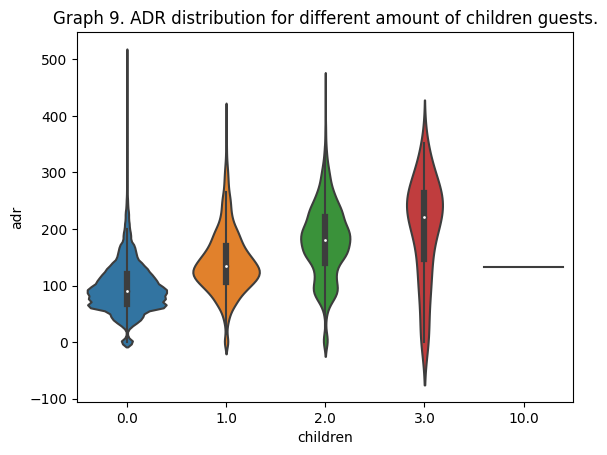

In [26]:
sns.violinplot(data=df, x='children', y='adr', split=True)
plt.title('Graph 9. ADR distribution for different amount of children guests.')

Graph 9 shows that the more children the higher the mean adr.

Did somebody enter 10 instead of 1 for children? If we look at the orange violin bar (1.0 kid) its adr is most dense at around the same adr as the adr for 10.0 kids.

Let's see if adr will also be higher if there are more adult gusets. 

Text(0.5, 1.0, 'Graph 10. ADR distribution for different amount of adult guests.')

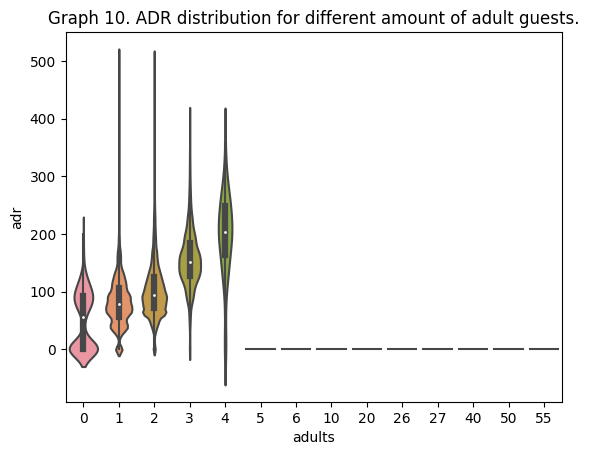

In [27]:
sns.violinplot(data=df, x='adults', y='adr', split=True)
plt.title('Graph 10. ADR distribution for different amount of adult guests.')

If adults > 4 it seems that ADR is 0... Can the ADR be 0 every time when the stay was canceled?

In [28]:
show = df[['is_canceled', 'adr']]
show = show[show['is_canceled'] == 1]
show

,is_canceled,adr
8,1,82.0
9,1,105.5
10,1,123.0
27,1,107.0
32,1,108.3
...,...,...
110280,1,0.0
111355,1,65.0
111924,1,65.0
111925,1,65.0


Nope.. I don't know how the adr is calculated here... I guess I will just leave these records with high adult and children counts 

In [29]:
# child_mask = df['children'] > 9
# df.loc[child_mask, 'children'] = 1

### Now let's see the correlations to treat the missing values

In [30]:
# Let's see correlation again
df.corr()['children'].transform('abs').sort_values(ascending=False)

children                          1.000000
adr                               0.341170
total_of_special_requests         0.081742
required_car_parking_spaces       0.056252
arrival_date_year                 0.054627
booking_changes                   0.048959
stays_in_weekend_nights           0.045800
stays_in_week_nights              0.044206
agent                             0.041070
lead_time                         0.037621
days_in_waiting_list              0.033273
is_repeated_guest                 0.032852
company                           0.030931
adults                            0.030448
previous_cancellations            0.024731
babies                            0.024029
previous_bookings_not_canceled    0.021070
arrival_date_day_of_month         0.014544
arrival_date_week_number          0.005513
is_canceled                       0.005049
Name: children, dtype: float64

The strongest correlation to 'children' corresponds to adr variable. In hotel terms, adr is the average daily rate. However adr is not discrete it doesn't make a lot of sense to impute the mean for different adr values.

The second most correlated var is 'total_of_special_requests' but as you can see below, since in general people tend to have 0 children it also does not make sense to input these mean values.

__I decided to impute the most frequent value which is 0 children for the Nan values in children variable.__

In [31]:
mean_children_by_s_r = df.groupby('total_of_special_requests')['children'].agg({'mean'})
mean_children_by_s_r

,mean
total_of_special_requests,
0,0.082072
1,0.115733
2,0.163788
3,0.233480
4,0.211765
5,0.200000


### Imputing 0 for missing values for 'children'

In [32]:
# Preparing boolean array with missing value(s) for later 
na_children = df['children'].isna()

# Imputing
df.loc[na_children,'children'] = 0

df['children'] = df['children'].astype('int64')

# df.info()

### Let's explore categorical column 'country'

In [33]:
df['country'].value_counts()

PRT    48589
GBR    12128
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 177, dtype: int64

In [34]:
df['country'].isna().sum()

488

It is not really viable to infer what's the missing country using the other categorical columns present in the dataset. We could run contingency test to compare with other categorical vars but I don't think that's best approach.

__Instead, I will fillna with 'Unknown'.__

In [35]:
df['country'] = df['country'].replace(np.NaN, 'U') \
                             .replace('U', 'Unknown')
df['country'].isna().sum() #sanity check

0

### 'agent' and 'company' both floats

In [36]:
df['agent'].isna().sum()

16340

In [37]:
df['company'].isna().sum()

112591

In [38]:
# Let's see correlation
df.corr()['agent'].transform('abs').sort_values(ascending=False)

agent                             1.000000
company                           0.350746
stays_in_week_nights              0.182354
required_car_parking_spaces       0.177358
stays_in_weekend_nights           0.140693
is_canceled                       0.083095
lead_time                         0.069760
booking_changes                   0.066975
arrival_date_year                 0.063438
days_in_waiting_list              0.055150
children                          0.041073
babies                            0.036186
adults                            0.035596
total_of_special_requests         0.034170
is_repeated_guest                 0.031401
arrival_date_week_number          0.031188
adr                               0.025387
previous_bookings_not_canceled    0.023181
previous_cancellations            0.012487
arrival_date_day_of_month         0.001514
Name: agent, dtype: float64

Yeah, as expected, company and agent are most correlated. However, their values are really unique ids so again imputing some arbirary values like mean and median will not work here. 

Let's check if whenever company is missing, the agent is missing as well.

In [39]:
# Create a boolean mask for rows where 'company' is missing
company_missing_mask = df['company'].isnull()

# Create a boolean mask for rows where 'agent' is missing
agent_missing_mask = df['agent'].isnull()

# Check if the condition is true (company missing and agent missing) for all matching rows
is_condition_true = (company_missing_mask == agent_missing_mask).all()

# Count the occurrences where both 'company' and 'agent' are missing
count_missing_agent = agent_missing_mask.sum()

print(f"Count of occurrences where both 'company' and 'agent' are missing: {count_missing_agent}")

Count of occurrences where both 'company' and 'agent' are missing: 16340


So we can't use company and agent for imputing anyways. 

__These are floats, but the values correspond to unique ids so let's impute 'no_agent' and 'no_company' for both.__ 

This way we will see the influence of each in feature importance graph (graph 11). 

In [40]:
print(df['agent'].min(), df['company'].min())

1.0 6.0


In [41]:
df['agent'] = df['agent'].replace(np.NaN, 'no_agent')
df['company'] = df['company'].replace(np.NaN, 'no_company')

df['company'].isna().sum()
df['agent'].isna().sum()

0

## Feature engineering
 
I was considering to create another feature called 'observation_lag' that would show the difference (in days) between reservation status and arrival_date. 

However, it does not make a lot of sense because all negative values and would indicate a 'Check-Out' status and all positive would mean that the reservation was cancelled. 

Besides, we already have the 'lead_time' variable which is more what I wanted to create - lead time in hotel terms means the period of time (most typically measured in calendar days) between when a guest makes the reservation and the actual check-in/arrival date.

Fitting the model on these data does not make a lot of sense because it would assume that we already know what's the outcome. Lead time, however does not imply that the reservation was cancelled or not.

At any rate, I am leaving the code commented out to demostrate feature engineering for dates. 

In [42]:
# month_dict = {
#     'January': 1, 'February': 2, 'March': 3, 'April': 4,
#     'May': 5, 'June': 6, 'July': 7, 'August': 8,
#     'September': 9, 'October': 10, 'November': 11, 'December': 12
# }

# df['arrival_date_month'] = df['arrival_date_month'].map(month_dict) #will not have to encode month anymore

# # Concatenate the columns with "-" as separator and store in a new column

# df['arrival_date'] = df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'].astype(str) + '-' + df['arrival_date_day_of_month'].astype(str)
# df['arrival_date'] = pd.to_datetime(df['arrival_date'])
# df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# # Calculate the observation lag (difference between 'arrival_date' and 'reservation_status_date')

# df['obs_lag'] = (df['arrival_date'] - df['reservation_status_date']).dt.days

# # Sanity check

# df_check = df[(df['reservation_status'] == 'Canceled') & (df['obs_lag'] < 0)]
# df_check

# # Yeah this makes no sense...

## Encoding

In [44]:
# Print the column names
print(df.columns.tolist())

['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date']


We need to drop at least 3 columns:
- 'arrival_date_year' --> cannot infer seasonal patterns retrospectively from year, 
- 'reservation_status_date' --> we already use the arrival_to_status_lag (feature engineering), 
- 'reservation_status' --> essentially the same information as for 'is_cancelled' column, would lead to overfitting.

In [45]:
df_model = df.drop(['arrival_date_year', 'reservation_status_date', 'reservation_status'], axis=1)
df_model.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [46]:
# List all columns of 'object' data type. Encoding
cols_to_encode = df_model.select_dtypes(include=['object'])
cols_to_encode = cols_to_encode.columns.tolist()
# Print the column names
print(cols_to_encode)

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 'customer_type']


In [47]:
# ENCODING
df_encoded = pd.get_dummies(df_model[cols_to_encode], drop_first=True)
df_model = pd.concat([df_model, df_encoded], axis=1)
df_model.drop(columns=cols_to_encode, inplace=True)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119388 entries, 0 to 119389
Columns: 931 entries, is_canceled to customer_type_Transient-Party
dtypes: float64(1), int64(16), uint8(914)
memory usage: 120.5 MB


## Train test split

In [48]:
X = df_model.drop('is_canceled', axis=1)
y = df_model['is_canceled']

In [49]:
X.shape

(119388, 930)

In [50]:
y.shape

(119388,)

In [51]:
from sklearn.model_selection import train_test_split

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

Let's try stratified sampling to mitigate possible class imbalance

In [52]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Setting seed for reproducibility
SEED = 1

# Instantiate individual classifiers
# lr = LogisticRegression(random_state=SEED, max_iter=5000)
knn = KNN()
rf = RandomForestClassifier(random_state=SEED, n_estimators = 100)

# Define a list containing tuples (classifier_name, classifier)
classifiers = [ #('Logistic Regression', lr),
               ('K Nearest Neighbours', knn),
               ('Random Forest Regressor', rf)]

# Iterate over the defined list of tuples containing the classifiers
for clf_name, clf in classifiers:

    # Fit clf to the training set
    clf.fit(X_train, y_train)

    # Predict the labels
    y_pred = clf.predict(X_test)

    # Evaluate the accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

K Nearest Neighbours : 0.779
Random Forest Regressor : 0.892


I commented out Logistic Regression model because due to convergence issues I had to increase the max_iter argument, making it longer and longer the model to run.

Nevertheless, from two fitted models, we will choose RFR with raw accuracy of 0.892.

### Let's see the feature importance for the top 30 features:

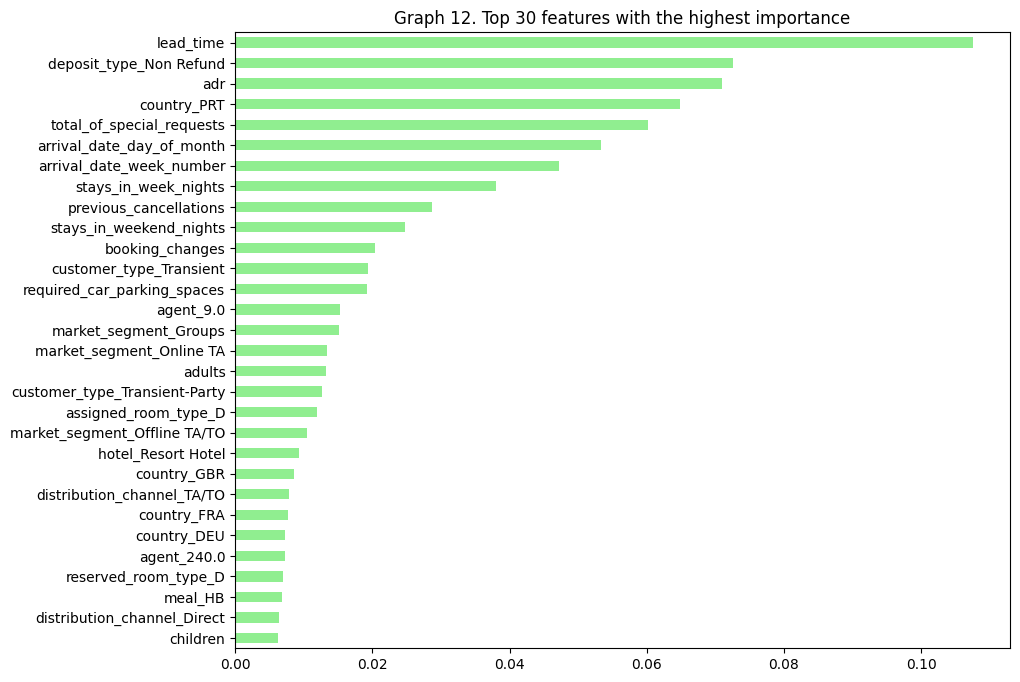

In [53]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Select the top 30 important features
top_30_importances = importances_sorted[-30:]

# Draw a horizontal barplot of the top 30 importances
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
top_30_importances.plot(kind='barh', color='lightgreen')
plt.title('Graph 12. Top 30 features with the highest importance')
plt.show()

__Fitting a Random Forest Classifier using 5-fold cross-validation Grid Search with for the following parameters:__ 
- n_estimators: 50, 100, 150
- criterion: 'gini', 'entropy'
- max_depth: from 1 to 6
- min_samples_leaf: 0.1, 0.3, 0.5
- max_features: 0.1, 0.2, 0.3, 0.4, 0.5

In [55]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150]#,
    #'criterion': ['gini', 'entropy'],
    #'max_depth': range(1, 6),
    #'min_samples_leaf': [0.1, 0.3, 0.5],
    #'max_features': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Create Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=SEED)

# Create GridSearchCV instance for Random Forest
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5)

# Fit the Random Forest model on development sample
grid_search_rf.fit(X_train, y_train)

# Print the best parameters for Random Forest
print("Best Parameters:", grid_search_rf.best_params_)

Best Parameters: {'n_estimators': 150}


In [56]:
from sklearn.metrics import accuracy_score

# Get the best parameters from Decision Tree grid search
best_rf_params = grid_search_rf.best_params_

# Create the best Decision Tree classifier
best_rf_classifier = RandomForestClassifier(random_state=SEED)

# Fit the best Decision Tree classifier on the development sample
best_rf_classifier.fit(X_train, y_train)

# Predict using the best Decision Tree and kNN classifiers on the validation sample
rf_val_predictions = best_rf_classifier.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_val_predictions)
rf_accuracy

0.8924951838512438